In [42]:
!pip install datasets transformers huggingface_hub torchaudio librosa jiwer -q
!pip install evaluate -q
!pip install 'accelerate>=0.26.0' -q
!pip install -U bitsandbytes peft -q
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 47.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 123.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 86.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 113.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 KB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 105.3 MB/s eta 0:00:0000:01


In [3]:
import zipfile
with zipfile.ZipFile('./common_voice.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [1]:
import os
import torch
import datasets
from datasets import Dataset, DatasetDict, Audio
import random
import json
import librosa
from tqdm import tqdm
import pandas as pd
from IPython.display import display, HTML

from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, Wav2Vec2ForCTC

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Mar  1 16:21:14 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:03:00.0 Off |                  Off |
| N/A   29C    P0    51W / 400W |      4MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Load in data and convert to a Dataset for training

In [3]:
audio_data = datasets.load_dataset("csv", data_files="cv-valid-train.csv")
audio_data

DatasetDict({
    train: Dataset({
        features: ['filename', 'text', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'],
        num_rows: 195776
    })
})

#### Common Voice dataset provides a lot more information about each audio file such as accent. However, I have decided to only use the `'filename'` and the `'text'` for fine tuning.

In [4]:
audio_data = audio_data.remove_columns(["accent", "age", "up_votes", "down_votes", "gender", "duration"])

In [5]:
## writing a function to display a random sample of the dataset
from datasets import ClassLabel

def show_random_elements(dataset, num_examples):
    assert num_examples <= len(dataset), "Number of samples more than length of dataset"
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset) - 1)
        while pick in picks:
            pick = random.randint(0, len(dataset) - 1)
        picks.append(pick)

    sample_df = pd.DataFrame(dataset[picks])
    display(HTML(sample_df.to_html()))

In [6]:
show_random_elements(audio_data["train"].remove_columns(["filename"]), num_examples=10)

,text
0,it's a beautiful miracle
1,they said nothing else
2,one of us is going to jail
3,it's extremely suspicious that there's no information about brains that didn't come from a brain
4,'m all about those invisible cosmic connections that transcend time and distance
5,the trouble with you is you let people step on you
6,hundreds of observers saw the flame that night and the night after
7,your appointment has been changed
8,three armed tribesmen approached and asked what the boy and the alchemist were doing there
9,finally a young woman approached who was not dressed in black


## 2. Prepare Dataset

In [7]:
# check if dataset contains special characters
import re

def check_special_char(dataset):
    for text in dataset['text']:
        regex = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
        if regex.search(text) == None:
            continue
        else:
            print(f"This text contains special characters: {text}")
            break
    return "Text does not contain special characters"

In [8]:
check_special_char(audio_data['train'])

'Text does not contain special characters'

#### The transcriptions look very clean and it seems a lot like dialogues. We can see that the transcriptions do not contains special characters such as `,.?!;:`. Since I will not be using a language model, it wont be hard to classify speech chunks in this dataset since they do no have these special characters which relate to characteristic sounds like excitement and confusion

In [9]:
def check_uppercase(dataset):
    for text in dataset['text']:
        for char in text:
            if char.isupper():
                print(text)
                return

    return "All the text are already in lowercase"
check_uppercase(audio_data['train'])

'All the text are already in lowercase'

#### There is no need to normalize the text as the text has already been normalized to lowercase

## 3. Prepare Tokenizer

#### In the transformers library, Wav2Vec2 model is accompanied by a `Wav2Vec2CTCTokenizer`, which helps to process the model's output format to text. The fine-tuned Wav2Vec2 needs to map a sequence of context representaitons to the correct transcription, hence a linear layer needs to be added on top. The linear layer is used to classify context representations to a token class.

#### The output size of this layer should be equal to the number of tokens in the vocabulary from the dataset used for fine-tuning.

#### I have decided to use the CTC algorithm and it classifies the speech chunks into letters, so I extract all the unique letters and build the vocabulary.

In [10]:
def create_vocab(batch):
    all_text = " ".join(batch['text'])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocab = audio_data.map(create_vocab, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=audio_data.column_names["train"])

Map:   0%|          | 0/195776 [00:00<?, ? examples/s]

In [11]:
vocab

DatasetDict({
    train: Dataset({
        features: ['vocab', 'all_text'],
        num_rows: 1
    })
})

In [12]:
vocab_list = list(set(vocab['train']['vocab'][0]))

# visualize the vocab
vocab_dict = {letter: number for number, letter in enumerate(vocab_list)}
vocab_dict

{'p': 0,
 'q': 1,
 'i': 2,
 'n': 3,
 'z': 4,
 'y': 5,
 'a': 6,
 'e': 7,
 'l': 8,
 't': 9,
 "'": 10,
 'f': 11,
 'h': 12,
 'c': 13,
 'k': 14,
 'b': 15,
 's': 16,
 'u': 17,
 'd': 18,
 'm': 19,
 'v': 20,
 'x': 21,
 ' ': 22,
 'g': 23,
 'j': 24,
 'o': 25,
 'r': 26,
 'w': 27}

#### All letters in the alphabet occur in the dataset and there is also the special characters `" "` and `'`. I did not remove these special characters because:
- the model need to predict when a words has finished or else it would just be a sequence of characters with no clear distinction between the words.
- the  `'` character helps to give a difference in meaning between it's and its

To make it clear that the space character has its own token class, i give it a more visible character: `|`

In [13]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

##### I also add a `"UNK"` and `"PAD"` token to help the model deal with characters not encounterd in the trainig set and to have "blank token" for CTC algorithm

In [14]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))

30


In [15]:
# save vocab as json file
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [16]:
# use json file to create an object of Wav2Vec2CTCTokenizer class
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

## 4. Create Feature Extractor

#### Wav2Vec2 was pretrained and fine-tuned on 960 hours of Librispeech which was sampled at 16kHz, hence we have to make sure the pseech input is also sampled at 16kHz.

#### Common Voice is sampled at 48kHz, thus it has to downsampled to 16kHz for training. I downsampled the training data 16kHz below

In [17]:
# feature extractor pipeline
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
# featur extractor and tokenizer wrapped into single class
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

#### Preprocess Data

In [18]:
audio_data

DatasetDict({
    train: Dataset({
        features: ['filename', 'text'],
        num_rows: 195776
    })
})

In [19]:
AUDIO_DIR = "./cv-valid-train"
audio_data['train'] = audio_data['train'].map(lambda x: {'filename': os.path.join(AUDIO_DIR, x['filename'])})
audio_data['train']['filename'][0]

'./cv-valid-train/cv-valid-train/sample-000000.mp3'

In [20]:
# split into train and validation set
audio_split = audio_data['train'].train_test_split(test_size=0.3)
train_data = audio_split['train']
valid_data = audio_split['test']

In [21]:
train_data, valid_data

(Dataset({
     features: ['filename', 'text'],
     num_rows: 137043
 }),
 Dataset({
     features: ['filename', 'text'],
     num_rows: 58733
 }))

#### I will resample the audio to 16 kHz since common voiceis sampled t 48 kHz. The reason for downsampling to 16 kHz is because WAv2Vec2 has been trained on audio samples sampled at 16 kHz and hence any input audio signal needs to be sampled at 16 kHz as well

#### The input values are obtained via the normalization done by `Wav2Vec2` processor.

In [22]:
import torchaudio

def prepare_dataset(batch):
    audio_array, sr = librosa.load(batch['filename'], sr=16_000)
    # batch['audio'] = audio_array
    # batch['sampling_rate'] = sr

    batch["input_values"] = processor(audio_array, sampling_rate=16_000).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [23]:
train_data = train_data.map(prepare_dataset, remove_columns=train_data.column_names, num_proc=4)

Map (num_proc=4):   0%|          | 0/137043 [00:00<?, ? examples/s]

/venv/main/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

In [24]:
len(train_data[0]['labels'])

81

In [25]:
valid_data = valid_data.map(prepare_dataset, remove_columns=['filename','text'], num_proc=4)

Map (num_proc=4):   0%|          | 0/58733 [00:00<?, ? examples/s]

/venv/main/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

#### Long input sequences require a lot of memory. Since `Wav2Vec2` is based on `self-attention` the memory requirement scales quadratically with the input length for long input sequences, hence I filter out audio sequences more than 5 seconds

In [26]:
max_input_length_in_sec = 5.0
train_data = train_data.filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

Filter:   0%|          | 0/137043 [00:00<?, ? examples/s]

In [27]:
train_data

Dataset({
    features: ['input_values', 'input_length', 'labels'],
    num_rows: 93427
})

#### The data collator treats the input_values and labels differently and applies separate padding functions on them. The speech input and output are of different modalities meaning that they should not be treated by the same padding function. Analogous to the common data collators, the padding tokens in the labels with -100 so that those tokens are not taken into account when computing the loss.

In [28]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [29]:
#create DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16, collate_fn=data_collator)
valid_dataloader = DataLoader(valid_data, shuffle=False, batch_size=16, collate_fn=data_collator)

### Training and Evaluation

In [30]:
from evaluate import load

# evaluation metric:wer
wer_metric = load("wer")

In [31]:
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.float16,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4"
# )

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-960h",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
    # quantization_config=quantization_config
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
model.freeze_feature_encoder()

In [33]:
# move model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model.device)

cuda:0


In [34]:
len(train_dataloader), len(valid_dataloader)

(5840, 3671)

#### Below is the training code using a native Pytorch loop. The hyperparameters selected are just random and no testing has been done on them as I do not have the resources to do a intensive hyperparameter testing.

In [35]:
# losses
train_losses = []
valid_losses = []
wer_scores = []

# optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

# training loop
for epoch in range(3):
    model.train()
    total_train_loss = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=True)
    for batch in progress_bar:
        input_values = batch["input_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_values, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} completed with Training Loss: {avg_train_loss:.4f}")

    # evaluate for each epoch
    model.eval()
    total_val_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        progress_bar = tqdm(valid_dataloader, desc=f"Epoch {epoch+1}", leave=True)
        for batch in progress_bar:
            input_values = batch["input_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_values, labels=labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

            pred_logits = outputs.logits
            pred_ids = torch.argmax(pred_logits, dim=-1).cpu().numpy()

            labels = labels.cpu().numpy()

            # decode predictions and labels
            pred_str = processor.batch_decode(pred_ids)
            label_str = processor.batch_decode(labels, group_tokens=True)

            all_predictions.extend(pred_str)
            all_labels.extend(label_str)

            progress_bar.set_postfix(loss=val_loss.item())

    # compute val loss
    avg_val_loss = total_val_loss / len(valid_dataloader)
    valid_losses.append(avg_val_loss)
    # compute wer
    wer = wer_metric.compute(predictions=all_predictions, references=all_labels)
    wer_scores.append(wer)
    print(f"Epoch {epoch + 1} completed with Validation Loss: {avg_val_loss:.4f} - WER {wer:.4f}")

/venv/main/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Epoch 1: 100%|██████████| 5840/5840 [1:22:10<00:00,  1.18it/s, loss=4.5] 


Epoch 1 completed with Training Loss: 4.8571


Epoch 1: 100%|██████████| 3671/3671 [50:42<00:00,  1.21it/s, loss=4.77]  


Epoch 1 completed with Validation Loss: 4.8179 - WER 1.0000


Epoch 2: 100%|██████████| 5840/5840 [1:22:07<00:00,  1.19it/s, loss=4.1] 


Epoch 2 completed with Training Loss: 4.7229


Epoch 2: 100%|██████████| 3671/3671 [50:50<00:00,  1.20it/s, loss=4.77]  


Epoch 2 completed with Validation Loss: 4.8179 - WER 1.0000


Epoch 3: 100%|██████████| 5840/5840 [1:22:16<00:00,  1.18it/s, loss=4.76]


Epoch 3 completed with Training Loss: 4.7432


Epoch 3: 100%|██████████| 3671/3671 [50:55<00:00,  1.20it/s, loss=4.77]  


Epoch 3 completed with Validation Loss: 4.8179 - WER 1.0000


In [36]:
del data_collator
del train_dataloader
del valid_dataloader
torch.cuda.empty_cache()

In [37]:
save_dir = "wav2vec2-large-960h-cv"
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

# Save model and processor
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

print(f"Model and processor saved to {save_dir}")

Model and processor saved to wav2vec2-large-960h-cv


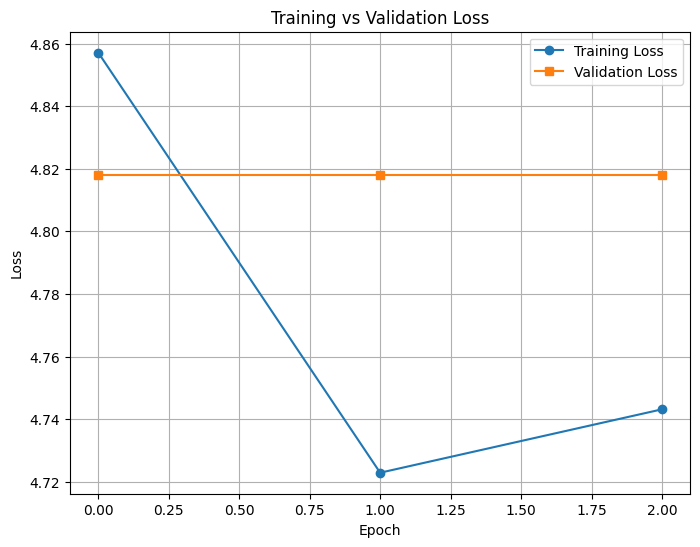

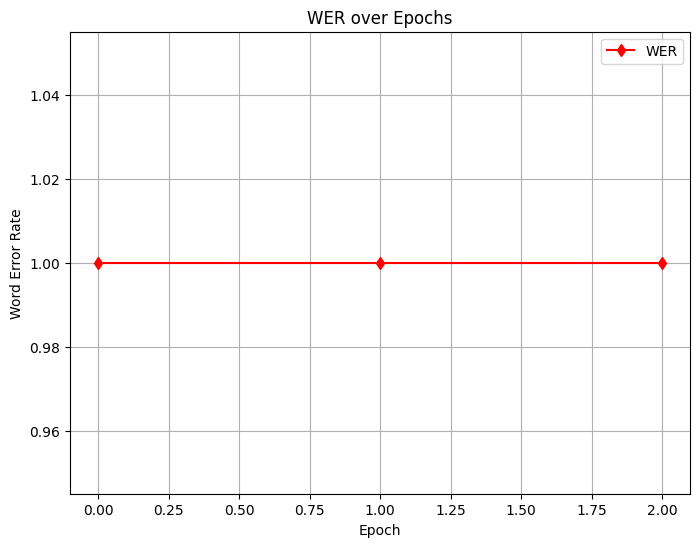

In [38]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss", marker="o")
plt.plot(valid_losses, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot WER scores
plt.figure(figsize=(8, 6))
plt.plot(wer_scores, label="WER", marker="d", color="red")
plt.xlabel("Epoch")
plt.ylabel("Word Error Rate")
plt.title("WER over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## Task 3c

In [39]:
processor = Wav2Vec2Processor.from_pretrained("wav2vec2-large-960h-cv")
model = Wav2Vec2ForCTC.from_pretrained("wav2vec2-large-960h-cv").to("cuda")

In [40]:
# transcribe audio in cv-valid-test
AUDIO_DIR = "./cv-valid-test"
CSV_PATH = "./cv-valid-test.csv"

df = pd.read_csv(CSV_PATH)

# create a list to store the transcriptions
transcriptions = []
wer_scores = []

model.eval()

# loop through the filenames in dataframe
for filename in tqdm(df['filename'], desc="Transcribing"):
    # check if file exists and open
    audio_path = os.path.join(AUDIO_DIR, filename)
    if os.path.exists(audio_path):
        with open(audio_path, "rb") as f:
            audio_input, sr = librosa.load(audio_path, sr=16000)

            # pad input values and return pt tensor
            input_values = processor(audio_input, sampling_rate=16000, return_tensors="pt", padding="longest").input_values.to("cuda")

            with torch.no_grad():
                # retrieve logits
                logits = model(input_values).logits

            # take argmax and decode
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = processor.batch_decode(predicted_ids)[0]
            transcriptions.append(transcription)
            try:
                reference_text = df.loc[df['filename'] == filename, 'text'].values[0]
                wer = wer_metric.compute(predictions=transcription, references=reference_text)
            except:
                wer = 1.0
            wer_scores.append(wer)
            print(f"WER sore: {wer}")

df['predicted'] = transcriptions
df['wer_scores'] = wer_scores

df.to_csv('performance.csv', index=False)

Transcribing:   0%|          | 1/3995 [00:01<1:07:06,  1.01s/it]

WER sore: 1.0


Transcribing:   0%|          | 2/3995 [00:02<1:08:46,  1.03s/it]

WER sore: 1.0
WER sore: 1.0


Transcribing:   0%|          | 4/3995 [00:03<48:13,  1.38it/s]  

WER sore: 1.0
WER sore: 1.0


Transcribing:   0%|          | 6/3995 [00:04<42:29,  1.56it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   0%|          | 8/3995 [00:05<39:51,  1.67it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   0%|          | 10/3995 [00:06<38:30,  1.72it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   0%|          | 12/3995 [00:07<37:42,  1.76it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   0%|          | 14/3995 [00:08<37:06,  1.79it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   0%|          | 16/3995 [00:09<36:40,  1.81it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   0%|          | 18/3995 [00:10<36:24,  1.82it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 20/3995 [00:11<36:15,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 22/3995 [00:12<36:05,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 24/3995 [00:13<36:04,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 26/3995 [00:15<35:51,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 28/3995 [00:16<35:45,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 30/3995 [00:17<35:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 32/3995 [00:18<35:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 34/3995 [00:19<35:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 36/3995 [00:20<35:36,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 38/3995 [00:21<35:53,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 40/3995 [00:22<35:52,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 42/3995 [00:23<35:50,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 44/3995 [00:24<35:39,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 46/3995 [00:25<35:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|          | 48/3995 [00:26<35:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|▏         | 50/3995 [00:28<35:30,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|▏         | 52/3995 [00:29<35:28,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|▏         | 54/3995 [00:30<35:33,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|▏         | 56/3995 [00:31<35:26,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   1%|▏         | 58/3995 [00:32<35:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 60/3995 [00:33<35:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 62/3995 [00:34<35:21,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 64/3995 [00:35<35:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 66/3995 [00:36<35:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 68/3995 [00:37<35:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 70/3995 [00:38<35:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 72/3995 [00:39<35:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 74/3995 [00:40<35:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 76/3995 [00:42<35:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 78/3995 [00:43<35:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 80/3995 [00:44<35:17,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 82/3995 [00:45<35:20,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 84/3995 [00:46<35:18,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 86/3995 [00:47<35:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 88/3995 [00:48<35:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 90/3995 [00:49<35:06,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 92/3995 [00:50<34:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 94/3995 [00:51<35:06,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 96/3995 [00:52<35:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   2%|▏         | 98/3995 [00:53<35:14,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 100/3995 [00:55<35:05,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 102/3995 [00:56<34:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 104/3995 [00:57<35:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 106/3995 [00:58<35:04,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 108/3995 [00:59<35:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 110/3995 [01:00<34:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 112/3995 [01:01<34:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 114/3995 [01:02<34:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 116/3995 [01:03<34:55,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 118/3995 [01:04<34:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 120/3995 [01:05<34:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 122/3995 [01:06<34:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 124/3995 [01:07<34:54,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 126/3995 [01:09<34:47,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 128/3995 [01:10<34:54,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 130/3995 [01:11<34:48,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 132/3995 [01:12<35:00,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 134/3995 [01:13<34:53,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 136/3995 [01:14<34:48,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   3%|▎         | 138/3995 [01:15<34:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▎         | 140/3995 [01:16<34:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▎         | 142/3995 [01:17<34:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▎         | 144/3995 [01:18<34:42,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▎         | 146/3995 [01:19<34:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▎         | 148/3995 [01:20<34:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 150/3995 [01:22<34:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 152/3995 [01:23<34:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 154/3995 [01:24<34:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 156/3995 [01:25<34:30,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 158/3995 [01:26<34:34,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 160/3995 [01:27<34:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 162/3995 [01:28<34:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 164/3995 [01:29<34:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 166/3995 [01:30<34:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 168/3995 [01:31<34:07,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 170/3995 [01:32<34:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 172/3995 [01:33<34:05,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 174/3995 [01:34<34:07,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 176/3995 [01:35<34:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   4%|▍         | 178/3995 [01:37<34:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 180/3995 [01:38<34:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 182/3995 [01:39<34:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 184/3995 [01:40<34:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 186/3995 [01:41<34:23,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 188/3995 [01:42<34:18,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 190/3995 [01:43<34:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 192/3995 [01:44<34:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 194/3995 [01:45<34:10,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 196/3995 [01:46<34:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▍         | 198/3995 [01:47<34:08,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 200/3995 [01:48<34:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 202/3995 [01:50<34:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 204/3995 [01:51<33:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 206/3995 [01:52<33:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 208/3995 [01:53<33:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 210/3995 [01:54<34:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 212/3995 [01:55<34:07,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 214/3995 [01:56<34:06,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 216/3995 [01:57<34:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   5%|▌         | 218/3995 [01:58<33:56,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 220/3995 [01:59<33:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 222/3995 [02:00<34:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 224/3995 [02:01<33:53,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 226/3995 [02:02<33:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 228/3995 [02:04<33:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 230/3995 [02:05<33:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 232/3995 [02:06<33:33,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 234/3995 [02:07<33:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 236/3995 [02:08<33:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 238/3995 [02:09<33:23,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 240/3995 [02:10<33:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 242/3995 [02:11<33:24,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 244/3995 [02:12<33:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 246/3995 [02:13<33:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▌         | 248/3995 [02:14<33:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▋         | 250/3995 [02:15<33:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▋         | 252/3995 [02:16<33:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▋         | 254/3995 [02:17<33:42,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▋         | 256/3995 [02:19<33:49,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   6%|▋         | 258/3995 [02:20<33:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 260/3995 [02:21<33:36,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 262/3995 [02:22<33:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 264/3995 [02:23<33:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 266/3995 [02:24<33:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 268/3995 [02:25<33:31,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 270/3995 [02:26<33:31,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 272/3995 [02:27<33:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 274/3995 [02:28<33:31,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 276/3995 [02:29<33:34,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 278/3995 [02:30<33:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 280/3995 [02:31<33:10,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 282/3995 [02:33<33:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 284/3995 [02:34<33:08,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 286/3995 [02:35<33:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 288/3995 [02:36<33:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 290/3995 [02:37<33:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 292/3995 [02:38<33:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 294/3995 [02:39<33:27,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 296/3995 [02:40<33:24,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   7%|▋         | 298/3995 [02:41<33:18,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 300/3995 [02:42<33:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 302/3995 [02:43<33:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 304/3995 [02:44<33:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 306/3995 [02:45<33:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 308/3995 [02:47<33:07,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 310/3995 [02:48<33:06,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 312/3995 [02:49<33:06,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 314/3995 [02:50<33:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 316/3995 [02:51<33:10,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 318/3995 [02:52<33:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 320/3995 [02:53<32:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 322/3995 [02:54<32:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 324/3995 [02:55<32:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 326/3995 [02:56<32:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 328/3995 [02:57<32:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 330/3995 [02:58<32:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 332/3995 [02:59<32:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 334/3995 [03:01<32:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 336/3995 [03:02<32:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   8%|▊         | 338/3995 [03:03<32:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▊         | 340/3995 [03:04<32:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▊         | 342/3995 [03:05<32:35,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▊         | 344/3995 [03:06<32:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▊         | 346/3995 [03:07<33:01,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▊         | 348/3995 [03:08<32:54,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 350/3995 [03:09<32:46,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 352/3995 [03:10<32:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 354/3995 [03:11<32:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 356/3995 [03:12<32:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 358/3995 [03:13<32:42,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 360/3995 [03:15<32:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 362/3995 [03:16<32:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 364/3995 [03:17<32:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 366/3995 [03:18<32:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 368/3995 [03:19<32:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 370/3995 [03:20<32:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 372/3995 [03:21<32:45,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 374/3995 [03:22<32:34,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 376/3995 [03:23<32:47,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:   9%|▉         | 378/3995 [03:24<32:44,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 380/3995 [03:25<32:39,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 382/3995 [03:26<32:31,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 384/3995 [03:28<32:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 386/3995 [03:29<32:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 388/3995 [03:30<32:13,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 390/3995 [03:31<32:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 392/3995 [03:32<32:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 394/3995 [03:33<32:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 396/3995 [03:34<32:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|▉         | 398/3995 [03:35<32:20,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 400/3995 [03:36<32:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 402/3995 [03:37<32:01,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 404/3995 [03:38<32:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 406/3995 [03:39<32:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 408/3995 [03:40<32:01,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 410/3995 [03:41<31:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 412/3995 [03:43<31:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 414/3995 [03:44<32:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 416/3995 [03:45<32:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  10%|█         | 418/3995 [03:46<32:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 420/3995 [03:47<32:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 422/3995 [03:48<32:13,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 424/3995 [03:49<32:05,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 426/3995 [03:50<31:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 428/3995 [03:51<31:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 430/3995 [03:52<31:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 432/3995 [03:53<31:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 434/3995 [03:54<31:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 436/3995 [03:55<31:45,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 438/3995 [03:57<31:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 440/3995 [03:58<31:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 442/3995 [03:59<31:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 444/3995 [04:00<31:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 446/3995 [04:01<31:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█         | 448/3995 [04:02<31:40,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█▏        | 450/3995 [04:03<31:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█▏        | 452/3995 [04:04<31:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█▏        | 454/3995 [04:05<31:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█▏        | 456/3995 [04:06<32:02,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  11%|█▏        | 458/3995 [04:07<31:58,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 460/3995 [04:08<31:54,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 462/3995 [04:09<32:13,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 464/3995 [04:11<32:02,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 466/3995 [04:12<31:53,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 468/3995 [04:13<31:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 470/3995 [04:14<31:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 472/3995 [04:15<31:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 474/3995 [04:16<31:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 476/3995 [04:17<31:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 478/3995 [04:18<31:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 480/3995 [04:19<31:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 482/3995 [04:20<31:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 484/3995 [04:21<31:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 486/3995 [04:22<31:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 488/3995 [04:23<31:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 490/3995 [04:25<31:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 492/3995 [04:26<31:30,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 494/3995 [04:27<31:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 496/3995 [04:28<31:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  12%|█▏        | 498/3995 [04:29<31:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 500/3995 [04:30<31:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 502/3995 [04:31<31:24,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 504/3995 [04:32<31:24,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 506/3995 [04:33<31:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 508/3995 [04:34<31:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 510/3995 [04:35<31:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 512/3995 [04:36<31:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 514/3995 [04:37<31:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 516/3995 [04:38<31:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 518/3995 [04:40<31:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 520/3995 [04:41<31:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 522/3995 [04:42<31:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 524/3995 [04:43<31:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 526/3995 [04:44<31:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 528/3995 [04:45<31:13,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 530/3995 [04:46<31:24,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 532/3995 [04:47<31:20,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 534/3995 [04:48<31:15,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 536/3995 [04:49<31:08,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  13%|█▎        | 538/3995 [04:50<30:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▎        | 540/3995 [04:51<30:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▎        | 542/3995 [04:53<30:48,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▎        | 544/3995 [04:54<30:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▎        | 546/3995 [04:55<30:45,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▎        | 548/3995 [04:56<30:38,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 550/3995 [04:57<30:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 552/3995 [04:58<30:45,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 554/3995 [04:59<30:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 556/3995 [05:00<30:41,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 558/3995 [05:01<30:41,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 560/3995 [05:02<30:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 562/3995 [05:03<30:35,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 564/3995 [05:04<30:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 566/3995 [05:05<30:34,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 568/3995 [05:06<30:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 570/3995 [05:08<30:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 572/3995 [05:09<30:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 574/3995 [05:10<30:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 576/3995 [05:11<30:49,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  14%|█▍        | 578/3995 [05:12<30:51,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 580/3995 [05:13<30:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 582/3995 [05:14<30:46,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 584/3995 [05:15<30:41,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 586/3995 [05:16<30:37,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 588/3995 [05:17<30:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 590/3995 [05:18<30:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 592/3995 [05:19<30:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 594/3995 [05:20<30:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 596/3995 [05:22<30:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▍        | 598/3995 [05:23<30:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 600/3995 [05:24<30:30,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 602/3995 [05:25<30:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 604/3995 [05:26<30:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 606/3995 [05:27<30:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 608/3995 [05:28<30:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 610/3995 [05:29<30:26,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 612/3995 [05:30<30:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 614/3995 [05:31<30:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 616/3995 [05:32<30:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  15%|█▌        | 618/3995 [05:33<30:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 620/3995 [05:34<30:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 622/3995 [05:36<30:08,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 624/3995 [05:37<30:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 626/3995 [05:38<30:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 628/3995 [05:39<30:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 630/3995 [05:40<30:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 632/3995 [05:41<30:23,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 634/3995 [05:42<30:19,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 636/3995 [05:43<30:37,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 638/3995 [05:44<30:24,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 640/3995 [05:45<30:10,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 642/3995 [05:46<30:13,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 644/3995 [05:47<30:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 646/3995 [05:49<30:10,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▌        | 648/3995 [05:50<30:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▋        | 650/3995 [05:51<30:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▋        | 652/3995 [05:52<29:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▋        | 654/3995 [05:53<29:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▋        | 656/3995 [05:54<29:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  16%|█▋        | 658/3995 [05:55<29:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 660/3995 [05:56<29:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 662/3995 [05:57<30:09,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 664/3995 [05:58<30:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 666/3995 [05:59<29:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 668/3995 [06:00<29:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 670/3995 [06:01<29:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 672/3995 [06:03<29:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 674/3995 [06:04<29:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 676/3995 [06:05<29:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 678/3995 [06:06<29:51,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 680/3995 [06:07<29:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 682/3995 [06:08<29:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 684/3995 [06:09<29:51,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 686/3995 [06:10<29:53,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 688/3995 [06:11<29:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 690/3995 [06:12<29:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 692/3995 [06:13<29:41,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 694/3995 [06:14<29:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 696/3995 [06:15<29:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  17%|█▋        | 698/3995 [06:17<29:37,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 700/3995 [06:18<29:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 702/3995 [06:19<29:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 704/3995 [06:20<29:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 706/3995 [06:21<29:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 708/3995 [06:22<29:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 710/3995 [06:23<29:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 712/3995 [06:24<29:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 714/3995 [06:25<29:16,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 716/3995 [06:26<29:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 718/3995 [06:27<29:16,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 720/3995 [06:28<29:15,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 722/3995 [06:29<29:13,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 724/3995 [06:30<29:12,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 726/3995 [06:32<29:11,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 728/3995 [06:33<29:10,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 730/3995 [06:34<29:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 732/3995 [06:35<29:23,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 734/3995 [06:36<29:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 736/3995 [06:37<29:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  18%|█▊        | 738/3995 [06:38<29:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▊        | 740/3995 [06:39<29:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▊        | 742/3995 [06:40<29:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▊        | 744/3995 [06:41<29:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▊        | 746/3995 [06:42<28:58,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▊        | 748/3995 [06:43<29:15,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 750/3995 [06:44<29:18,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 752/3995 [06:46<29:20,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 754/3995 [06:47<29:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 756/3995 [06:48<29:06,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 758/3995 [06:49<28:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 760/3995 [06:50<28:52,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 762/3995 [06:51<28:51,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 764/3995 [06:52<28:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 766/3995 [06:53<28:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 768/3995 [06:54<28:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 770/3995 [06:55<28:48,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 772/3995 [06:56<28:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 774/3995 [06:57<28:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 776/3995 [06:58<28:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  19%|█▉        | 778/3995 [07:00<28:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 780/3995 [07:01<28:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 782/3995 [07:02<28:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 784/3995 [07:03<28:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 786/3995 [07:04<28:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 788/3995 [07:05<28:52,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 790/3995 [07:06<28:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 792/3995 [07:07<28:47,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 794/3995 [07:08<28:55,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 796/3995 [07:09<28:46,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|█▉        | 798/3995 [07:10<28:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 800/3995 [07:11<28:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 802/3995 [07:12<28:31,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 804/3995 [07:14<28:42,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 806/3995 [07:15<28:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 808/3995 [07:16<28:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 810/3995 [07:17<28:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 812/3995 [07:18<28:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 814/3995 [07:19<28:36,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 816/3995 [07:20<28:34,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  20%|██        | 818/3995 [07:21<28:35,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 820/3995 [07:22<28:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 822/3995 [07:23<28:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 824/3995 [07:24<28:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 826/3995 [07:25<28:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 828/3995 [07:26<28:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 830/3995 [07:28<28:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 832/3995 [07:29<28:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 834/3995 [07:30<28:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 836/3995 [07:31<28:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 838/3995 [07:32<28:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 840/3995 [07:33<28:07,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 842/3995 [07:34<28:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 844/3995 [07:35<28:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 846/3995 [07:36<28:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██        | 848/3995 [07:37<28:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██▏       | 850/3995 [07:38<28:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██▏       | 852/3995 [07:39<28:20,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██▏       | 854/3995 [07:40<28:19,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██▏       | 856/3995 [07:42<28:21,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  21%|██▏       | 858/3995 [07:43<28:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 860/3995 [07:44<28:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 862/3995 [07:45<28:13,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 864/3995 [07:46<28:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 866/3995 [07:47<28:09,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 868/3995 [07:48<28:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 870/3995 [07:49<27:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 872/3995 [07:50<28:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 874/3995 [07:51<28:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 876/3995 [07:52<27:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 878/3995 [07:53<27:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 880/3995 [07:54<27:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 882/3995 [07:56<27:47,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 884/3995 [07:57<27:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 886/3995 [07:58<27:56,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 888/3995 [07:59<27:56,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 890/3995 [08:00<27:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 892/3995 [08:01<27:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 894/3995 [08:02<27:41,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 896/3995 [08:03<27:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  22%|██▏       | 898/3995 [08:04<27:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 900/3995 [08:05<27:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 902/3995 [08:06<27:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 904/3995 [08:07<27:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 906/3995 [08:08<27:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 908/3995 [08:09<27:34,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 910/3995 [08:11<27:32,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 912/3995 [08:12<27:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 914/3995 [08:13<27:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 916/3995 [08:14<27:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 918/3995 [08:15<27:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 920/3995 [08:16<27:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 922/3995 [08:17<27:36,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 924/3995 [08:18<27:36,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 926/3995 [08:19<27:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 928/3995 [08:20<27:23,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 930/3995 [08:21<27:19,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 932/3995 [08:22<27:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 934/3995 [08:23<27:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 936/3995 [08:25<27:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  23%|██▎       | 938/3995 [08:26<27:33,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▎       | 940/3995 [08:27<27:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▎       | 942/3995 [08:28<27:26,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▎       | 944/3995 [08:29<27:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▎       | 946/3995 [08:30<27:13,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▎       | 948/3995 [08:31<27:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 950/3995 [08:32<27:21,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 952/3995 [08:33<27:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 954/3995 [08:34<27:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 956/3995 [08:35<27:20,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 958/3995 [08:36<27:21,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 960/3995 [08:37<27:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 962/3995 [08:39<27:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 964/3995 [08:40<27:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 966/3995 [08:41<27:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 968/3995 [08:42<27:26,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 970/3995 [08:43<27:22,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 972/3995 [08:44<27:18,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 974/3995 [08:45<27:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 976/3995 [08:46<27:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  24%|██▍       | 978/3995 [08:47<27:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 980/3995 [08:48<27:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 982/3995 [08:49<26:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 984/3995 [08:50<26:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 986/3995 [08:51<26:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 988/3995 [08:53<26:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 990/3995 [08:54<27:04,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 992/3995 [08:55<27:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 994/3995 [08:56<27:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 996/3995 [08:57<26:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▍       | 998/3995 [08:58<26:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1000/3995 [08:59<27:05,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1002/3995 [09:00<26:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1004/3995 [09:01<26:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1006/3995 [09:02<26:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1008/3995 [09:03<26:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1010/3995 [09:04<26:50,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1012/3995 [09:06<26:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1014/3995 [09:07<26:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1016/3995 [09:08<26:34,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  25%|██▌       | 1018/3995 [09:09<26:33,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1020/3995 [09:10<26:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1022/3995 [09:11<26:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1024/3995 [09:12<26:23,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1026/3995 [09:13<26:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1028/3995 [09:14<26:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1030/3995 [09:15<26:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1032/3995 [09:16<26:26,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1034/3995 [09:17<26:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1036/3995 [09:18<26:36,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1038/3995 [09:19<26:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1040/3995 [09:21<26:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1042/3995 [09:22<26:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1044/3995 [09:23<26:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1046/3995 [09:24<26:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▌       | 1048/3995 [09:25<26:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▋       | 1050/3995 [09:26<26:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▋       | 1052/3995 [09:27<26:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▋       | 1054/3995 [09:28<26:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▋       | 1056/3995 [09:29<26:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  26%|██▋       | 1058/3995 [09:30<26:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1060/3995 [09:31<26:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1062/3995 [09:32<26:11,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1064/3995 [09:33<26:08,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1066/3995 [09:34<26:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1068/3995 [09:36<26:09,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1070/3995 [09:37<26:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1072/3995 [09:38<26:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1074/3995 [09:39<26:05,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1076/3995 [09:40<26:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1078/3995 [09:41<26:20,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1080/3995 [09:42<26:13,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1082/3995 [09:43<26:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1084/3995 [09:44<26:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1086/3995 [09:45<26:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1088/3995 [09:46<26:09,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1091/3995 [09:48<22:24,  2.16it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1092/3995 [09:49<28:02,  1.73it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1094/3995 [09:50<27:07,  1.78it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1096/3995 [09:51<26:46,  1.80it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  27%|██▋       | 1098/3995 [09:52<26:30,  1.82it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1100/3995 [09:53<26:16,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1102/3995 [09:54<26:07,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1104/3995 [09:55<25:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1106/3995 [09:56<25:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1108/3995 [09:57<25:43,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1110/3995 [09:58<25:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1112/3995 [09:59<25:56,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1114/3995 [10:00<25:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1116/3995 [10:01<25:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1118/3995 [10:03<25:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1120/3995 [10:04<25:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1122/3995 [10:05<25:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1124/3995 [10:06<25:38,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1126/3995 [10:07<25:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1128/3995 [10:08<25:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1130/3995 [10:09<25:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1132/3995 [10:10<25:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1134/3995 [10:11<25:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1136/3995 [10:12<25:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  28%|██▊       | 1138/3995 [10:13<25:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▊       | 1140/3995 [10:14<25:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▊       | 1142/3995 [10:15<25:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▊       | 1144/3995 [10:16<25:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▊       | 1146/3995 [10:18<25:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▊       | 1148/3995 [10:19<25:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1150/3995 [10:20<25:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1152/3995 [10:21<25:35,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1154/3995 [10:22<25:33,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1156/3995 [10:23<25:32,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1158/3995 [10:24<25:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1160/3995 [10:25<25:33,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1162/3995 [10:26<25:29,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1164/3995 [10:27<25:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1166/3995 [10:28<25:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1168/3995 [10:29<25:26,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1170/3995 [10:31<25:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1172/3995 [10:32<25:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1174/3995 [10:33<25:23,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1176/3995 [10:34<25:21,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  29%|██▉       | 1178/3995 [10:35<25:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1180/3995 [10:36<25:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1182/3995 [10:37<25:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1184/3995 [10:38<25:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1186/3995 [10:39<25:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1188/3995 [10:40<25:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1190/3995 [10:41<25:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1192/3995 [10:42<25:00,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1194/3995 [10:43<24:56,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1196/3995 [10:44<25:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|██▉       | 1198/3995 [10:46<25:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1200/3995 [10:47<24:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1202/3995 [10:48<24:56,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1204/3995 [10:49<25:05,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1206/3995 [10:50<25:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1208/3995 [10:51<24:53,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1210/3995 [10:52<24:51,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1212/3995 [10:53<24:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1214/3995 [10:54<24:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1216/3995 [10:55<24:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  30%|███       | 1218/3995 [10:56<24:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1220/3995 [10:57<24:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1222/3995 [10:58<24:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1224/3995 [10:59<24:56,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1226/3995 [11:01<24:56,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1228/3995 [11:02<24:51,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1230/3995 [11:03<24:53,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1232/3995 [11:04<24:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1234/3995 [11:05<24:52,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1236/3995 [11:06<24:54,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1238/3995 [11:07<24:47,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1240/3995 [11:08<24:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1242/3995 [11:09<24:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1244/3995 [11:10<24:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1246/3995 [11:11<24:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███       | 1248/3995 [11:12<24:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███▏      | 1250/3995 [11:14<24:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███▏      | 1252/3995 [11:15<24:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███▏      | 1254/3995 [11:16<24:45,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███▏      | 1256/3995 [11:17<24:37,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  31%|███▏      | 1258/3995 [11:18<24:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1260/3995 [11:19<24:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1262/3995 [11:20<24:33,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1264/3995 [11:21<24:40,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1266/3995 [11:22<24:39,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1268/3995 [11:23<24:31,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1270/3995 [11:24<24:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1272/3995 [11:25<24:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1274/3995 [11:26<24:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1276/3995 [11:28<24:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1278/3995 [11:29<24:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1280/3995 [11:30<24:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1282/3995 [11:31<24:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1284/3995 [11:32<24:13,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1286/3995 [11:33<24:10,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1288/3995 [11:34<24:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1290/3995 [11:35<24:08,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1292/3995 [11:36<24:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1294/3995 [11:37<24:02,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1296/3995 [11:38<23:57,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  32%|███▏      | 1298/3995 [11:39<24:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1300/3995 [11:40<23:59,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1302/3995 [11:41<23:55,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1304/3995 [11:42<23:58,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1306/3995 [11:44<23:56,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1308/3995 [11:45<24:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1310/3995 [11:46<24:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1312/3995 [11:47<24:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1314/3995 [11:48<23:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1316/3995 [11:49<23:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1318/3995 [11:50<23:53,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1320/3995 [11:51<23:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1322/3995 [11:52<23:48,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1324/3995 [11:53<23:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1326/3995 [11:54<23:42,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1328/3995 [11:55<23:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1330/3995 [11:56<23:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1332/3995 [11:57<23:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1334/3995 [11:59<23:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1336/3995 [12:00<23:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  33%|███▎      | 1338/3995 [12:01<23:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▎      | 1340/3995 [12:02<23:43,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▎      | 1342/3995 [12:03<23:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▎      | 1344/3995 [12:04<23:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▎      | 1346/3995 [12:05<24:07,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▎      | 1348/3995 [12:06<24:10,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1350/3995 [12:07<24:01,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1352/3995 [12:08<23:52,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1354/3995 [12:09<23:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1356/3995 [12:10<23:33,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1358/3995 [12:12<23:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1360/3995 [12:13<23:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1362/3995 [12:14<23:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1364/3995 [12:15<23:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1366/3995 [12:16<23:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1368/3995 [12:17<23:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1370/3995 [12:18<23:23,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1372/3995 [12:19<23:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1374/3995 [12:20<23:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1376/3995 [12:21<23:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  34%|███▍      | 1378/3995 [12:22<23:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1380/3995 [12:23<23:19,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1382/3995 [12:24<23:16,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1384/3995 [12:25<23:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1386/3995 [12:27<23:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1388/3995 [12:28<23:12,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1390/3995 [12:29<23:13,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1392/3995 [12:30<23:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1394/3995 [12:31<23:28,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1396/3995 [12:32<23:30,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▍      | 1398/3995 [12:33<23:22,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1400/3995 [12:34<23:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1402/3995 [12:35<23:18,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1404/3995 [12:36<23:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1406/3995 [12:37<23:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1408/3995 [12:38<23:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1410/3995 [12:39<23:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1412/3995 [12:41<23:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1414/3995 [12:42<22:59,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1416/3995 [12:43<23:02,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  35%|███▌      | 1418/3995 [12:44<23:00,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1420/3995 [12:45<23:00,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1422/3995 [12:46<23:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1424/3995 [12:47<23:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1426/3995 [12:48<23:05,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1428/3995 [12:49<23:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1430/3995 [12:50<23:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1432/3995 [12:51<23:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1434/3995 [12:52<23:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1436/3995 [12:53<22:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1438/3995 [12:55<22:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1440/3995 [12:56<22:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1442/3995 [12:57<22:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1444/3995 [12:58<22:47,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1446/3995 [12:59<22:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▌      | 1448/3995 [13:00<22:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▋      | 1450/3995 [13:01<22:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▋      | 1452/3995 [13:02<22:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▋      | 1454/3995 [13:03<22:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▋      | 1456/3995 [13:04<22:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  36%|███▋      | 1458/3995 [13:05<22:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1460/3995 [13:06<22:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1462/3995 [13:07<22:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1464/3995 [13:08<22:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1466/3995 [13:10<22:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1468/3995 [13:11<22:46,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1470/3995 [13:12<22:50,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1472/3995 [13:13<22:59,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1474/3995 [13:14<22:54,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1476/3995 [13:15<22:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1478/3995 [13:16<22:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1480/3995 [13:17<22:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1482/3995 [13:18<22:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1484/3995 [13:19<22:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1486/3995 [13:20<22:37,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1488/3995 [13:21<22:36,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1490/3995 [13:23<22:35,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1492/3995 [13:24<22:37,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1494/3995 [13:25<22:41,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1496/3995 [13:26<22:39,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  37%|███▋      | 1498/3995 [13:27<22:34,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1500/3995 [13:28<22:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1502/3995 [13:29<22:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1504/3995 [13:30<22:25,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1506/3995 [13:31<22:22,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1508/3995 [13:32<22:25,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1510/3995 [13:33<22:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1512/3995 [13:34<22:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1514/3995 [13:36<22:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1516/3995 [13:37<22:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1518/3995 [13:38<22:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1520/3995 [13:39<22:15,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1522/3995 [13:40<22:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1524/3995 [13:41<22:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1526/3995 [13:42<22:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1528/3995 [13:43<22:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1530/3995 [13:44<22:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1532/3995 [13:45<22:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1534/3995 [13:46<22:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1536/3995 [13:47<21:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  38%|███▊      | 1538/3995 [13:48<21:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▊      | 1540/3995 [13:50<22:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▊      | 1542/3995 [13:51<21:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▊      | 1544/3995 [13:52<21:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▊      | 1546/3995 [13:53<22:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▊      | 1548/3995 [13:54<21:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1550/3995 [13:55<21:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1552/3995 [13:56<21:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1554/3995 [13:57<21:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1556/3995 [13:58<21:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1558/3995 [13:59<21:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1560/3995 [14:00<21:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1562/3995 [14:01<21:42,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1564/3995 [14:02<21:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1566/3995 [14:03<21:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1568/3995 [14:05<21:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1570/3995 [14:06<21:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1572/3995 [14:07<21:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1574/3995 [14:08<21:45,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1576/3995 [14:09<21:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  39%|███▉      | 1578/3995 [14:10<21:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|███▉      | 1580/3995 [14:11<21:45,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|███▉      | 1582/3995 [14:12<21:42,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|███▉      | 1584/3995 [14:13<21:41,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|███▉      | 1586/3995 [14:14<21:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|███▉      | 1588/3995 [14:15<21:45,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|███▉      | 1590/3995 [14:16<21:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|███▉      | 1592/3995 [14:18<21:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|███▉      | 1594/3995 [14:19<21:36,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|███▉      | 1596/3995 [14:20<21:37,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1598/3995 [14:21<21:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1600/3995 [14:22<21:22,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1602/3995 [14:23<21:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1604/3995 [14:24<21:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1606/3995 [14:25<21:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1608/3995 [14:26<21:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1610/3995 [14:27<21:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1612/3995 [14:28<21:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1614/3995 [14:29<21:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  40%|████      | 1616/3995 [14:30<21:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1618/3995 [14:31<21:12,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1620/3995 [14:33<21:11,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1622/3995 [14:34<21:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1624/3995 [14:35<21:18,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1626/3995 [14:36<21:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1628/3995 [14:37<21:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1630/3995 [14:38<21:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1632/3995 [14:39<21:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1634/3995 [14:40<21:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1636/3995 [14:41<21:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1638/3995 [14:42<21:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1640/3995 [14:43<21:02,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1642/3995 [14:44<20:59,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1644/3995 [14:45<21:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████      | 1646/3995 [14:47<21:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████▏     | 1648/3995 [14:48<21:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████▏     | 1650/3995 [14:49<21:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████▏     | 1652/3995 [14:50<21:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████▏     | 1654/3995 [14:51<21:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  41%|████▏     | 1656/3995 [14:52<20:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1658/3995 [14:53<20:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1660/3995 [14:54<21:06,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1662/3995 [14:55<20:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1664/3995 [14:56<20:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1666/3995 [14:57<20:47,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1668/3995 [14:58<21:10,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1670/3995 [14:59<20:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1672/3995 [15:01<20:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1674/3995 [15:02<20:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1676/3995 [15:03<20:54,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1678/3995 [15:04<20:52,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1680/3995 [15:05<20:54,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1682/3995 [15:06<20:48,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1684/3995 [15:07<20:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1686/3995 [15:08<20:47,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1688/3995 [15:09<20:55,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1690/3995 [15:10<20:51,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1692/3995 [15:11<20:57,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1694/3995 [15:12<20:51,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  42%|████▏     | 1696/3995 [15:14<20:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1698/3995 [15:15<20:42,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1700/3995 [15:16<20:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1702/3995 [15:17<20:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1704/3995 [15:18<20:35,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1706/3995 [15:19<20:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1708/3995 [15:20<20:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1710/3995 [15:21<20:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1712/3995 [15:22<20:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1714/3995 [15:23<20:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1716/3995 [15:24<20:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1718/3995 [15:25<20:19,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1720/3995 [15:26<20:17,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1722/3995 [15:28<20:15,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1724/3995 [15:29<20:15,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1726/3995 [15:30<20:11,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1728/3995 [15:31<20:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1730/3995 [15:32<20:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1732/3995 [15:33<20:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1734/3995 [15:34<20:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  43%|████▎     | 1736/3995 [15:35<20:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▎     | 1738/3995 [15:36<20:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▎     | 1740/3995 [15:37<20:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▎     | 1742/3995 [15:38<20:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▎     | 1744/3995 [15:39<20:21,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▎     | 1746/3995 [15:40<20:19,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1748/3995 [15:42<20:17,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1750/3995 [15:43<20:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1752/3995 [15:44<20:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1754/3995 [15:45<20:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1756/3995 [15:46<20:17,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1758/3995 [15:47<20:14,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1760/3995 [15:48<20:08,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1762/3995 [15:49<20:06,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1764/3995 [15:50<19:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1766/3995 [15:51<19:53,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1768/3995 [15:52<19:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1770/3995 [15:53<19:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1772/3995 [15:54<20:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1774/3995 [15:56<19:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  44%|████▍     | 1776/3995 [15:57<19:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1778/3995 [15:58<19:56,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1780/3995 [15:59<19:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1782/3995 [16:00<19:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1784/3995 [16:01<19:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1786/3995 [16:02<19:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1788/3995 [16:03<19:42,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1790/3995 [16:04<19:41,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1792/3995 [16:05<19:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1794/3995 [16:06<19:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▍     | 1796/3995 [16:07<19:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1798/3995 [16:08<19:34,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1800/3995 [16:09<19:35,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1802/3995 [16:11<19:32,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1804/3995 [16:12<19:32,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1806/3995 [16:13<19:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1808/3995 [16:14<19:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1810/3995 [16:15<19:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1812/3995 [16:16<19:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1814/3995 [16:17<19:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  45%|████▌     | 1816/3995 [16:18<19:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1818/3995 [16:19<19:34,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1820/3995 [16:20<19:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1822/3995 [16:21<19:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1824/3995 [16:22<19:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1826/3995 [16:23<19:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1828/3995 [16:25<19:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1830/3995 [16:26<19:20,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1832/3995 [16:27<19:19,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1834/3995 [16:28<19:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1836/3995 [16:29<19:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1838/3995 [16:30<19:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1840/3995 [16:31<19:13,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1842/3995 [16:32<19:12,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1844/3995 [16:33<19:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▌     | 1846/3995 [16:34<19:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▋     | 1848/3995 [16:35<19:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▋     | 1850/3995 [16:36<19:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▋     | 1852/3995 [16:37<19:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▋     | 1854/3995 [16:38<19:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  46%|████▋     | 1856/3995 [16:40<19:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1858/3995 [16:41<19:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1860/3995 [16:42<19:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1862/3995 [16:43<19:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1864/3995 [16:44<18:58,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1866/3995 [16:45<18:57,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1868/3995 [16:46<18:57,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1870/3995 [16:47<18:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1872/3995 [16:48<19:06,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1874/3995 [16:49<19:04,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1876/3995 [16:50<19:05,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1878/3995 [16:51<19:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1880/3995 [16:52<18:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1882/3995 [16:54<18:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1884/3995 [16:55<18:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1886/3995 [16:56<18:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1888/3995 [16:57<18:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1890/3995 [16:58<18:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1892/3995 [16:59<18:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1894/3995 [17:00<18:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  47%|████▋     | 1896/3995 [17:01<18:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1898/3995 [17:02<18:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1900/3995 [17:03<18:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1902/3995 [17:04<18:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1904/3995 [17:05<18:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1906/3995 [17:06<18:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1908/3995 [17:08<18:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1910/3995 [17:09<18:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1912/3995 [17:10<18:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1914/3995 [17:11<18:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1916/3995 [17:12<18:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1918/3995 [17:13<18:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1920/3995 [17:14<18:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1922/3995 [17:15<18:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1924/3995 [17:16<18:29,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1926/3995 [17:17<18:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1928/3995 [17:18<18:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1930/3995 [17:19<18:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1932/3995 [17:20<18:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1934/3995 [17:21<18:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  48%|████▊     | 1936/3995 [17:23<18:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▊     | 1938/3995 [17:24<18:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▊     | 1940/3995 [17:25<18:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▊     | 1942/3995 [17:26<18:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▊     | 1944/3995 [17:27<18:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▊     | 1946/3995 [17:28<18:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1948/3995 [17:29<18:17,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1950/3995 [17:30<18:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1952/3995 [17:31<18:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1954/3995 [17:32<18:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1956/3995 [17:33<18:12,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1958/3995 [17:34<18:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1960/3995 [17:35<18:08,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1962/3995 [17:36<18:05,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1964/3995 [17:38<18:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1966/3995 [17:39<18:02,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1968/3995 [17:40<18:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1970/3995 [17:41<18:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1972/3995 [17:42<18:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1974/3995 [17:43<18:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  49%|████▉     | 1976/3995 [17:44<18:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1978/3995 [17:45<18:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1980/3995 [17:46<18:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1982/3995 [17:47<18:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1984/3995 [17:48<17:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1986/3995 [17:49<17:53,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1988/3995 [17:50<17:50,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1990/3995 [17:51<17:53,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1992/3995 [17:53<17:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1994/3995 [17:54<17:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|████▉     | 1996/3995 [17:55<17:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 1998/3995 [17:56<17:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 2000/3995 [17:57<17:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 2002/3995 [17:58<17:47,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 2004/3995 [17:59<17:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 2006/3995 [18:00<17:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 2008/3995 [18:01<17:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 2010/3995 [18:02<17:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 2012/3995 [18:03<17:49,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 2014/3995 [18:04<17:48,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  50%|█████     | 2016/3995 [18:05<17:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2018/3995 [18:07<17:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2020/3995 [18:08<17:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2022/3995 [18:09<17:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2024/3995 [18:10<17:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2026/3995 [18:11<17:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2028/3995 [18:12<17:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2030/3995 [18:13<17:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2032/3995 [18:14<17:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2034/3995 [18:15<17:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2036/3995 [18:16<17:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2038/3995 [18:17<17:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2040/3995 [18:18<17:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2042/3995 [18:19<17:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2044/3995 [18:20<17:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████     | 2046/3995 [18:22<17:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████▏    | 2048/3995 [18:23<17:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████▏    | 2050/3995 [18:24<17:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████▏    | 2052/3995 [18:25<17:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████▏    | 2054/3995 [18:26<17:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  51%|█████▏    | 2056/3995 [18:27<17:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2058/3995 [18:28<17:26,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2060/3995 [18:29<17:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2062/3995 [18:30<17:16,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2064/3995 [18:31<17:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2066/3995 [18:32<17:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2068/3995 [18:33<17:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2070/3995 [18:34<17:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2072/3995 [18:36<17:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2074/3995 [18:37<17:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2076/3995 [18:38<17:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2078/3995 [18:39<17:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2080/3995 [18:40<17:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2082/3995 [18:41<17:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2084/3995 [18:42<17:02,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2086/3995 [18:43<16:59,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2088/3995 [18:44<17:01,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2090/3995 [18:45<16:59,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2092/3995 [18:46<17:00,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2094/3995 [18:47<17:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  52%|█████▏    | 2096/3995 [18:48<17:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2098/3995 [18:49<17:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2100/3995 [18:51<17:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2102/3995 [18:52<16:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2104/3995 [18:53<16:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2106/3995 [18:54<16:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2108/3995 [18:55<16:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2110/3995 [18:56<16:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2112/3995 [18:57<16:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2114/3995 [18:58<16:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2116/3995 [18:59<16:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2118/3995 [19:00<16:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2120/3995 [19:01<16:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2122/3995 [19:02<16:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2124/3995 [19:03<16:41,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2126/3995 [19:05<16:41,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2128/3995 [19:06<16:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2130/3995 [19:07<16:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2132/3995 [19:08<16:38,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2134/3995 [19:09<16:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  53%|█████▎    | 2136/3995 [19:10<16:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▎    | 2138/3995 [19:11<16:35,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▎    | 2140/3995 [19:12<16:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▎    | 2142/3995 [19:13<16:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▎    | 2144/3995 [19:14<16:31,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▎    | 2146/3995 [19:15<16:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2148/3995 [19:16<16:26,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2150/3995 [19:17<16:26,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2152/3995 [19:18<16:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2154/3995 [19:20<16:24,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2156/3995 [19:21<16:23,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2158/3995 [19:22<16:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2160/3995 [19:23<16:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2162/3995 [19:24<16:22,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2164/3995 [19:25<16:20,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2166/3995 [19:26<16:19,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2168/3995 [19:27<16:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2170/3995 [19:28<16:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2172/3995 [19:29<16:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2174/3995 [19:30<16:16,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  54%|█████▍    | 2176/3995 [19:31<16:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2178/3995 [19:32<16:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2180/3995 [19:33<16:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2182/3995 [19:35<16:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2184/3995 [19:36<16:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2186/3995 [19:37<16:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2188/3995 [19:38<16:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2190/3995 [19:39<16:15,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2192/3995 [19:40<16:20,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2194/3995 [19:41<16:18,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▍    | 2196/3995 [19:42<16:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2198/3995 [19:43<16:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2200/3995 [19:44<16:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2202/3995 [19:45<16:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2204/3995 [19:46<16:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2206/3995 [19:48<16:05,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2208/3995 [19:49<16:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2210/3995 [19:50<16:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2212/3995 [19:51<16:01,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2214/3995 [19:52<16:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  55%|█████▌    | 2216/3995 [19:53<15:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2218/3995 [19:54<16:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2220/3995 [19:55<15:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2222/3995 [19:56<15:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2224/3995 [19:57<15:56,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2226/3995 [19:58<15:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2228/3995 [19:59<15:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2230/3995 [20:00<15:57,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2232/3995 [20:02<15:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2234/3995 [20:03<15:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2236/3995 [20:04<15:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2238/3995 [20:05<15:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2240/3995 [20:06<15:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2242/3995 [20:07<15:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2244/3995 [20:08<15:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▌    | 2246/3995 [20:09<15:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▋    | 2248/3995 [20:10<15:42,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▋    | 2250/3995 [20:11<15:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▋    | 2252/3995 [20:12<15:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▋    | 2254/3995 [20:13<15:45,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  56%|█████▋    | 2256/3995 [20:14<15:42,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2258/3995 [20:16<15:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2260/3995 [20:17<15:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2262/3995 [20:18<15:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2264/3995 [20:19<15:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2266/3995 [20:20<15:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2268/3995 [20:21<15:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2270/3995 [20:22<15:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2272/3995 [20:23<15:23,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2274/3995 [20:24<15:22,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2276/3995 [20:25<15:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2278/3995 [20:26<15:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2280/3995 [20:27<15:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2282/3995 [20:28<15:25,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2284/3995 [20:30<15:23,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2286/3995 [20:31<15:22,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2288/3995 [20:32<15:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2290/3995 [20:33<15:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2292/3995 [20:34<15:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2294/3995 [20:35<15:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  57%|█████▋    | 2296/3995 [20:36<15:10,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2298/3995 [20:37<15:15,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2300/3995 [20:38<15:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2302/3995 [20:39<15:13,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2304/3995 [20:40<15:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2306/3995 [20:41<15:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2308/3995 [20:42<15:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2310/3995 [20:44<15:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2312/3995 [20:45<15:08,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2314/3995 [20:46<15:06,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2316/3995 [20:47<15:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2318/3995 [20:48<15:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2320/3995 [20:49<14:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2322/3995 [20:50<14:55,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2324/3995 [20:51<14:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2326/3995 [20:52<14:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2328/3995 [20:53<15:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2330/3995 [20:54<14:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2332/3995 [20:55<14:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2334/3995 [20:56<14:56,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  58%|█████▊    | 2336/3995 [20:58<14:55,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▊    | 2338/3995 [20:59<14:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▊    | 2340/3995 [21:00<14:55,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▊    | 2342/3995 [21:01<14:51,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▊    | 2344/3995 [21:02<14:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▊    | 2346/3995 [21:03<14:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2348/3995 [21:04<14:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2350/3995 [21:05<14:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2352/3995 [21:06<14:40,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2354/3995 [21:07<14:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2356/3995 [21:08<14:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2358/3995 [21:09<14:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2360/3995 [21:10<14:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2362/3995 [21:11<14:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2364/3995 [21:13<14:34,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2366/3995 [21:14<14:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2368/3995 [21:15<14:32,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2370/3995 [21:16<14:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2372/3995 [21:17<14:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2374/3995 [21:18<14:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  59%|█████▉    | 2376/3995 [21:19<14:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2378/3995 [21:20<14:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2380/3995 [21:21<14:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2382/3995 [21:22<14:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2384/3995 [21:23<14:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2386/3995 [21:24<14:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2388/3995 [21:25<14:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2390/3995 [21:27<14:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2392/3995 [21:28<14:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2394/3995 [21:29<14:17,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|█████▉    | 2396/3995 [21:30<14:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2398/3995 [21:31<14:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2400/3995 [21:32<14:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2402/3995 [21:33<14:13,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2404/3995 [21:34<14:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2406/3995 [21:35<14:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2408/3995 [21:36<14:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2410/3995 [21:37<14:09,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2412/3995 [21:38<14:07,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2414/3995 [21:39<14:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  60%|██████    | 2416/3995 [21:41<14:24,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2418/3995 [21:42<14:17,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2420/3995 [21:43<14:14,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2422/3995 [21:44<14:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2424/3995 [21:45<14:09,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2426/3995 [21:46<14:07,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2428/3995 [21:47<14:05,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2430/3995 [21:48<14:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2432/3995 [21:49<14:03,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2434/3995 [21:50<14:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2436/3995 [21:51<14:01,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2438/3995 [21:52<14:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2440/3995 [21:54<14:01,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2442/3995 [21:55<14:01,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2444/3995 [21:56<13:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████    | 2446/3995 [21:57<13:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████▏   | 2448/3995 [21:58<13:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████▏   | 2450/3995 [21:59<13:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████▏   | 2452/3995 [22:00<13:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████▏   | 2454/3995 [22:01<13:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  61%|██████▏   | 2456/3995 [22:02<13:43,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2458/3995 [22:03<13:40,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2460/3995 [22:04<13:38,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2462/3995 [22:05<13:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2464/3995 [22:06<13:40,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2466/3995 [22:07<13:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2468/3995 [22:09<13:34,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2470/3995 [22:10<13:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2472/3995 [22:11<13:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2474/3995 [22:12<13:34,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2476/3995 [22:13<13:32,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2478/3995 [22:14<13:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2480/3995 [22:15<13:31,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2482/3995 [22:16<13:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2484/3995 [22:17<13:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2486/3995 [22:18<13:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2488/3995 [22:19<13:34,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2490/3995 [22:20<13:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2492/3995 [22:21<13:31,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2494/3995 [22:23<13:31,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  62%|██████▏   | 2496/3995 [22:24<13:31,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2498/3995 [22:25<13:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2500/3995 [22:26<13:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2502/3995 [22:27<13:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2504/3995 [22:28<13:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2506/3995 [22:29<13:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2508/3995 [22:30<13:17,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2510/3995 [22:31<13:15,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2512/3995 [22:32<13:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2514/3995 [22:33<13:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2516/3995 [22:34<13:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2518/3995 [22:35<13:11,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2520/3995 [22:36<13:10,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2522/3995 [22:38<13:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2524/3995 [22:39<13:08,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2526/3995 [22:40<13:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2528/3995 [22:41<13:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2530/3995 [22:42<13:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2532/3995 [22:43<13:02,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2534/3995 [22:44<13:01,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  63%|██████▎   | 2536/3995 [22:45<13:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▎   | 2538/3995 [22:46<13:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▎   | 2540/3995 [22:47<13:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▎   | 2542/3995 [22:48<13:03,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▎   | 2544/3995 [22:49<13:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▎   | 2546/3995 [22:50<12:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2548/3995 [22:52<13:09,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2550/3995 [22:53<13:04,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2552/3995 [22:54<12:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2554/3995 [22:55<12:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2556/3995 [22:56<12:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2558/3995 [22:57<12:58,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2560/3995 [22:58<12:55,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2562/3995 [22:59<12:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2564/3995 [23:00<12:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2566/3995 [23:01<12:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2568/3995 [23:02<12:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2570/3995 [23:03<12:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2572/3995 [23:04<12:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2574/3995 [23:06<12:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  64%|██████▍   | 2576/3995 [23:07<12:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2578/3995 [23:08<12:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2580/3995 [23:09<12:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2582/3995 [23:10<12:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2584/3995 [23:11<12:41,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2586/3995 [23:12<12:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2588/3995 [23:13<12:39,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2590/3995 [23:14<12:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2592/3995 [23:15<12:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2594/3995 [23:16<12:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▍   | 2596/3995 [23:17<12:36,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2598/3995 [23:19<12:35,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2600/3995 [23:20<12:33,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2602/3995 [23:21<12:32,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2604/3995 [23:22<12:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2606/3995 [23:23<12:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2608/3995 [23:24<12:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2610/3995 [23:25<12:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2612/3995 [23:26<12:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2614/3995 [23:27<12:20,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  65%|██████▌   | 2616/3995 [23:28<12:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2618/3995 [23:29<12:17,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2620/3995 [23:30<12:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2622/3995 [23:31<12:15,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2624/3995 [23:32<12:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2626/3995 [23:34<12:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2628/3995 [23:35<12:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2630/3995 [23:36<12:29,  1.82it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2632/3995 [23:37<12:22,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2634/3995 [23:38<12:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2636/3995 [23:39<12:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2638/3995 [23:40<12:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2640/3995 [23:41<12:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2642/3995 [23:42<12:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2644/3995 [23:43<12:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▌   | 2646/3995 [23:44<12:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▋   | 2648/3995 [23:45<12:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▋   | 2650/3995 [23:47<12:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▋   | 2652/3995 [23:48<12:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▋   | 2654/3995 [23:49<12:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  66%|██████▋   | 2656/3995 [23:50<11:56,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2658/3995 [23:51<11:55,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2660/3995 [23:52<11:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2662/3995 [23:53<11:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2664/3995 [23:54<11:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2666/3995 [23:55<11:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2668/3995 [23:56<11:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2670/3995 [23:57<11:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2672/3995 [23:58<11:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2674/3995 [23:59<11:48,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2676/3995 [24:00<11:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2678/3995 [24:02<11:43,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2680/3995 [24:03<11:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2682/3995 [24:04<11:43,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2684/3995 [24:05<11:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2686/3995 [24:06<11:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2688/3995 [24:07<11:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2690/3995 [24:08<11:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2692/3995 [24:09<11:45,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2694/3995 [24:10<11:41,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  67%|██████▋   | 2696/3995 [24:11<11:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2698/3995 [24:12<11:41,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2700/3995 [24:13<11:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2702/3995 [24:14<11:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2704/3995 [24:16<11:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2706/3995 [24:17<11:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2708/3995 [24:18<11:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2710/3995 [24:19<11:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2712/3995 [24:20<11:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2714/3995 [24:21<11:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2716/3995 [24:22<11:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2718/3995 [24:23<11:24,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2720/3995 [24:24<11:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2722/3995 [24:25<11:18,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2724/3995 [24:26<11:19,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2726/3995 [24:27<11:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2728/3995 [24:28<11:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2730/3995 [24:29<11:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2732/3995 [24:31<11:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2735/3995 [24:32<09:44,  2.16it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  68%|██████▊   | 2736/3995 [24:33<12:08,  1.73it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▊   | 2738/3995 [24:34<11:46,  1.78it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▊   | 2740/3995 [24:35<11:32,  1.81it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▊   | 2742/3995 [24:36<11:26,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▊   | 2744/3995 [24:37<11:18,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▊   | 2746/3995 [24:38<11:17,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2748/3995 [24:39<11:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2750/3995 [24:40<11:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2752/3995 [24:41<11:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2754/3995 [24:42<11:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2756/3995 [24:43<11:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2758/3995 [24:45<11:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2760/3995 [24:46<11:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2762/3995 [24:47<11:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2764/3995 [24:48<11:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2766/3995 [24:49<10:58,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2768/3995 [24:50<11:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2770/3995 [24:51<10:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2772/3995 [24:52<10:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2774/3995 [24:53<10:51,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  69%|██████▉   | 2776/3995 [24:54<10:50,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2778/3995 [24:55<10:50,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2780/3995 [24:56<10:51,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2782/3995 [24:57<10:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2784/3995 [24:59<10:48,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2786/3995 [25:00<10:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2788/3995 [25:01<10:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2790/3995 [25:02<10:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2792/3995 [25:03<10:48,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2794/3995 [25:04<10:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|██████▉   | 2796/3995 [25:05<10:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2798/3995 [25:06<10:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2800/3995 [25:07<10:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2802/3995 [25:08<10:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2804/3995 [25:09<10:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2806/3995 [25:10<10:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2808/3995 [25:11<10:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2810/3995 [25:12<10:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2812/3995 [25:14<10:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2814/3995 [25:15<10:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  70%|███████   | 2816/3995 [25:16<10:32,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2818/3995 [25:17<10:29,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2820/3995 [25:18<10:29,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2822/3995 [25:19<10:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2824/3995 [25:20<10:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2826/3995 [25:21<10:26,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2828/3995 [25:22<10:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2830/3995 [25:23<10:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2832/3995 [25:24<10:23,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2834/3995 [25:25<10:22,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2836/3995 [25:26<10:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2838/3995 [25:27<10:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2840/3995 [25:29<10:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2842/3995 [25:30<10:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2844/3995 [25:31<10:16,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████   | 2846/3995 [25:32<10:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████▏  | 2848/3995 [25:33<10:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████▏  | 2850/3995 [25:34<10:13,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████▏  | 2852/3995 [25:35<10:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████▏  | 2854/3995 [25:36<10:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  71%|███████▏  | 2856/3995 [25:37<10:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2858/3995 [25:38<10:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2860/3995 [25:39<10:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2862/3995 [25:40<10:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2864/3995 [25:41<10:05,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2866/3995 [25:43<10:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2868/3995 [25:44<10:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2870/3995 [25:45<10:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2872/3995 [25:46<10:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2874/3995 [25:47<10:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2876/3995 [25:48<10:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2878/3995 [25:49<10:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2880/3995 [25:50<10:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2882/3995 [25:51<09:56,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2884/3995 [25:52<09:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2886/3995 [25:53<09:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2888/3995 [25:54<09:52,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2890/3995 [25:55<09:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2892/3995 [25:56<09:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2894/3995 [25:58<09:50,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  72%|███████▏  | 2896/3995 [25:59<09:48,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2898/3995 [26:00<09:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2900/3995 [26:01<09:45,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2902/3995 [26:02<09:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2904/3995 [26:03<09:42,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2906/3995 [26:04<09:41,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2908/3995 [26:05<09:42,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2910/3995 [26:06<09:40,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2912/3995 [26:07<09:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2914/3995 [26:08<09:38,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2916/3995 [26:09<09:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2918/3995 [26:10<09:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2920/3995 [26:11<09:35,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2922/3995 [26:13<09:33,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2924/3995 [26:14<09:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2926/3995 [26:15<09:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2928/3995 [26:16<09:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2930/3995 [26:17<09:29,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2932/3995 [26:18<09:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2934/3995 [26:19<09:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  73%|███████▎  | 2936/3995 [26:20<09:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▎  | 2938/3995 [26:21<09:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▎  | 2940/3995 [26:22<09:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▎  | 2942/3995 [26:23<09:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▎  | 2944/3995 [26:24<09:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▎  | 2946/3995 [26:25<09:28,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2948/3995 [26:27<09:24,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2950/3995 [26:28<09:23,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2952/3995 [26:29<09:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2954/3995 [26:30<09:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2956/3995 [26:31<09:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2958/3995 [26:32<09:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2960/3995 [26:33<09:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2962/3995 [26:34<09:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2964/3995 [26:35<09:17,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2966/3995 [26:36<09:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2968/3995 [26:37<09:13,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2970/3995 [26:38<09:14,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2972/3995 [26:39<09:13,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2974/3995 [26:41<09:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  74%|███████▍  | 2976/3995 [26:42<09:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2978/3995 [26:43<09:09,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2980/3995 [26:44<09:07,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2982/3995 [26:45<09:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2984/3995 [26:46<09:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2986/3995 [26:47<09:03,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2988/3995 [26:48<09:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2990/3995 [26:49<09:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2992/3995 [26:50<09:01,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2994/3995 [26:51<08:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▍  | 2996/3995 [26:52<09:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 2998/3995 [26:53<08:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 3000/3995 [26:55<08:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 3002/3995 [26:56<08:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 3004/3995 [26:57<08:55,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 3006/3995 [26:58<09:03,  1.82it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 3008/3995 [26:59<08:58,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 3010/3995 [27:00<08:53,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 3012/3995 [27:01<08:50,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 3014/3995 [27:02<08:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  75%|███████▌  | 3016/3995 [27:03<08:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3018/3995 [27:04<08:47,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3020/3995 [27:05<08:46,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3022/3995 [27:06<08:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3024/3995 [27:07<08:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3026/3995 [27:09<08:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3028/3995 [27:10<08:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3030/3995 [27:11<08:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3032/3995 [27:12<08:34,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3034/3995 [27:13<08:33,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3036/3995 [27:14<08:31,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3038/3995 [27:15<08:30,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3040/3995 [27:16<08:28,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3042/3995 [27:17<08:26,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3044/3995 [27:18<08:26,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▌  | 3046/3995 [27:19<08:26,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▋  | 3048/3995 [27:20<08:24,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▋  | 3050/3995 [27:21<08:24,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▋  | 3052/3995 [27:22<08:24,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▋  | 3054/3995 [27:23<08:21,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  76%|███████▋  | 3056/3995 [27:25<08:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3058/3995 [27:26<08:19,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3060/3995 [27:27<08:20,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3062/3995 [27:28<08:19,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3064/3995 [27:29<08:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3066/3995 [27:30<08:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3068/3995 [27:31<08:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3070/3995 [27:32<08:15,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3072/3995 [27:33<08:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3074/3995 [27:34<08:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3076/3995 [27:35<08:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3078/3995 [27:36<08:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3080/3995 [27:37<08:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3082/3995 [27:39<08:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3084/3995 [27:40<08:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3086/3995 [27:41<08:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3088/3995 [27:42<08:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3090/3995 [27:43<08:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3092/3995 [27:44<08:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3094/3995 [27:45<08:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  77%|███████▋  | 3096/3995 [27:46<08:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3098/3995 [27:47<08:00,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3100/3995 [27:48<07:58,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3102/3995 [27:49<07:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3104/3995 [27:50<07:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3106/3995 [27:51<07:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3108/3995 [27:52<07:55,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3110/3995 [27:54<07:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3112/3995 [27:55<07:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3114/3995 [27:56<07:55,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3116/3995 [27:57<07:54,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3118/3995 [27:58<07:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3120/3995 [27:59<07:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3122/3995 [28:00<07:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3124/3995 [28:01<07:49,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3126/3995 [28:02<07:49,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3128/3995 [28:03<07:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3130/3995 [28:04<07:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3132/3995 [28:05<07:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3134/3995 [28:07<07:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  78%|███████▊  | 3136/3995 [28:08<07:40,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▊  | 3138/3995 [28:09<07:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▊  | 3140/3995 [28:10<07:41,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▊  | 3142/3995 [28:11<07:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▊  | 3144/3995 [28:12<07:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▊  | 3146/3995 [28:13<07:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3148/3995 [28:14<07:33,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3150/3995 [28:15<07:32,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3152/3995 [28:16<07:30,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3154/3995 [28:17<07:29,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3156/3995 [28:18<07:29,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3158/3995 [28:19<07:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3160/3995 [28:20<07:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3162/3995 [28:22<07:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3164/3995 [28:23<07:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3166/3995 [28:24<07:24,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3168/3995 [28:25<07:26,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3170/3995 [28:26<07:27,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3172/3995 [28:27<07:24,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3174/3995 [28:28<07:25,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  79%|███████▉  | 3176/3995 [28:29<07:23,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|███████▉  | 3178/3995 [28:30<07:21,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|███████▉  | 3180/3995 [28:31<07:19,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|███████▉  | 3182/3995 [28:32<07:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|███████▉  | 3184/3995 [28:33<07:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|███████▉  | 3186/3995 [28:34<07:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|███████▉  | 3188/3995 [28:36<07:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|███████▉  | 3190/3995 [28:37<07:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|███████▉  | 3192/3995 [28:38<07:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|███████▉  | 3194/3995 [28:39<07:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3196/3995 [28:40<07:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3198/3995 [28:41<07:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3200/3995 [28:42<07:05,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3202/3995 [28:43<07:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3204/3995 [28:44<07:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3206/3995 [28:45<07:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3208/3995 [28:46<07:01,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3210/3995 [28:47<06:59,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3212/3995 [28:48<06:58,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  80%|████████  | 3214/3995 [28:49<06:57,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3216/3995 [28:51<06:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3218/3995 [28:52<06:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3220/3995 [28:53<06:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3222/3995 [28:54<06:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3224/3995 [28:55<06:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3226/3995 [28:56<06:51,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3228/3995 [28:57<06:50,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3230/3995 [28:58<06:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3232/3995 [28:59<06:47,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3234/3995 [29:00<06:47,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3236/3995 [29:01<06:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3238/3995 [29:02<06:45,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3240/3995 [29:03<06:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3242/3995 [29:04<06:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████  | 3244/3995 [29:06<06:42,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████▏ | 3246/3995 [29:07<06:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████▏ | 3248/3995 [29:08<06:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████▏ | 3250/3995 [29:09<06:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████▏ | 3252/3995 [29:10<06:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  81%|████████▏ | 3254/3995 [29:11<06:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3256/3995 [29:12<06:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3258/3995 [29:13<06:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3260/3995 [29:14<06:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3262/3995 [29:15<06:35,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3264/3995 [29:16<06:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3266/3995 [29:17<06:30,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3268/3995 [29:18<06:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3270/3995 [29:20<06:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3272/3995 [29:21<06:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3274/3995 [29:22<06:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3276/3995 [29:23<06:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3278/3995 [29:24<06:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3280/3995 [29:25<06:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3282/3995 [29:26<06:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3284/3995 [29:27<06:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3286/3995 [29:28<06:19,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3288/3995 [29:29<06:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3290/3995 [29:30<06:17,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3292/3995 [29:31<06:16,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  82%|████████▏ | 3294/3995 [29:32<06:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3296/3995 [29:33<06:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3298/3995 [29:35<06:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3300/3995 [29:36<06:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3302/3995 [29:37<06:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3304/3995 [29:38<06:10,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3306/3995 [29:39<06:08,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3308/3995 [29:40<06:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3310/3995 [29:41<06:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3312/3995 [29:42<06:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3314/3995 [29:43<06:07,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3316/3995 [29:44<06:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3318/3995 [29:45<06:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3320/3995 [29:46<06:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3322/3995 [29:47<06:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3324/3995 [29:49<06:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3326/3995 [29:50<05:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3328/3995 [29:51<05:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3330/3995 [29:52<05:56,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3332/3995 [29:53<05:55,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  83%|████████▎ | 3334/3995 [29:54<05:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▎ | 3336/3995 [29:55<05:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▎ | 3338/3995 [29:56<05:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▎ | 3340/3995 [29:57<05:50,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▎ | 3342/3995 [29:58<05:52,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▎ | 3344/3995 [29:59<05:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3346/3995 [30:00<05:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3348/3995 [30:01<05:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3350/3995 [30:03<05:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3352/3995 [30:04<05:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3354/3995 [30:05<05:42,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3356/3995 [30:06<05:40,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3358/3995 [30:07<05:40,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3360/3995 [30:08<05:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3362/3995 [30:09<05:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3364/3995 [30:10<05:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3366/3995 [30:11<05:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3368/3995 [30:12<05:38,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3370/3995 [30:13<05:36,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3372/3995 [30:14<05:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  84%|████████▍ | 3374/3995 [30:15<05:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3376/3995 [30:16<05:34,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3378/3995 [30:18<05:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3380/3995 [30:19<05:31,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3382/3995 [30:20<05:30,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3384/3995 [30:21<05:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3386/3995 [30:22<05:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3388/3995 [30:23<05:28,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3390/3995 [30:24<05:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3392/3995 [30:25<05:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▍ | 3394/3995 [30:26<05:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3396/3995 [30:27<05:23,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3398/3995 [30:28<05:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3400/3995 [30:29<05:18,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3402/3995 [30:30<05:17,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3404/3995 [30:32<05:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3406/3995 [30:33<05:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3408/3995 [30:34<05:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3410/3995 [30:35<05:16,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3412/3995 [30:36<05:15,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  85%|████████▌ | 3414/3995 [30:37<05:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3416/3995 [30:38<05:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3418/3995 [30:39<05:11,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3420/3995 [30:40<05:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3422/3995 [30:41<05:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3424/3995 [30:42<05:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3426/3995 [30:43<05:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3428/3995 [30:44<05:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3430/3995 [30:46<05:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3432/3995 [30:47<05:01,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3434/3995 [30:48<05:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3436/3995 [30:49<04:59,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3438/3995 [30:50<04:57,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3440/3995 [30:51<04:55,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3442/3995 [30:52<04:55,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▌ | 3444/3995 [30:53<04:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▋ | 3446/3995 [30:54<04:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▋ | 3448/3995 [30:55<04:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▋ | 3450/3995 [30:56<04:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▋ | 3452/3995 [30:57<04:50,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  86%|████████▋ | 3454/3995 [30:58<04:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3456/3995 [30:59<04:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3458/3995 [31:01<04:47,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3460/3995 [31:02<04:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3462/3995 [31:03<04:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3464/3995 [31:04<04:44,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3466/3995 [31:05<04:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3468/3995 [31:06<04:43,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3470/3995 [31:07<04:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3472/3995 [31:08<04:40,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3474/3995 [31:09<04:39,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3476/3995 [31:10<04:37,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3478/3995 [31:11<04:36,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3480/3995 [31:12<04:35,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3482/3995 [31:13<04:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3484/3995 [31:14<04:35,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3486/3995 [31:16<04:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3488/3995 [31:17<04:33,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3490/3995 [31:18<04:32,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3492/3995 [31:19<04:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  87%|████████▋ | 3494/3995 [31:20<04:30,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3496/3995 [31:21<04:29,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3498/3995 [31:22<04:27,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3500/3995 [31:23<04:26,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3502/3995 [31:24<04:25,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3504/3995 [31:25<04:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3506/3995 [31:26<04:23,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3508/3995 [31:27<04:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3510/3995 [31:28<04:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3512/3995 [31:30<04:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3514/3995 [31:31<04:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3516/3995 [31:32<04:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3518/3995 [31:33<04:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3520/3995 [31:34<04:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3522/3995 [31:35<04:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3524/3995 [31:36<04:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3526/3995 [31:37<04:12,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3528/3995 [31:38<04:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3530/3995 [31:39<04:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3532/3995 [31:40<04:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  88%|████████▊ | 3534/3995 [31:41<04:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▊ | 3536/3995 [31:42<04:05,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▊ | 3538/3995 [31:44<04:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▊ | 3540/3995 [31:45<04:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▊ | 3542/3995 [31:46<04:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▊ | 3544/3995 [31:47<04:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3546/3995 [31:48<04:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3548/3995 [31:49<04:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3550/3995 [31:50<04:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3552/3995 [31:51<03:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3554/3995 [31:52<03:55,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3556/3995 [31:53<03:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3558/3995 [31:54<03:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3560/3995 [31:55<03:53,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3562/3995 [31:56<03:52,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3564/3995 [31:58<03:52,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3566/3995 [31:59<03:50,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3568/3995 [32:00<03:50,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3570/3995 [32:01<03:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3572/3995 [32:02<03:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  89%|████████▉ | 3574/3995 [32:03<03:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|████████▉ | 3576/3995 [32:04<03:45,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|████████▉ | 3578/3995 [32:05<03:43,  1.87it/s]

WER sore: 1.0


Transcribing:  90%|████████▉ | 3579/3995 [32:05<03:28,  1.99it/s]

WER sore: 1.0


Transcribing:  90%|████████▉ | 3580/3995 [32:07<04:23,  1.57it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|████████▉ | 3582/3995 [32:08<04:07,  1.67it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|████████▉ | 3585/3995 [32:09<03:26,  1.99it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|████████▉ | 3586/3995 [32:10<04:24,  1.55it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|████████▉ | 3588/3995 [32:11<04:05,  1.66it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|████████▉ | 3590/3995 [32:12<03:54,  1.72it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|████████▉ | 3592/3995 [32:13<03:47,  1.77it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|████████▉ | 3594/3995 [32:14<03:42,  1.80it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3596/3995 [32:15<03:38,  1.82it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3598/3995 [32:16<03:36,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3600/3995 [32:18<03:33,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3602/3995 [32:19<03:32,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3604/3995 [32:20<03:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3606/3995 [32:21<03:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3608/3995 [32:22<03:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3610/3995 [32:23<03:28,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3612/3995 [32:24<03:26,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  90%|█████████ | 3614/3995 [32:25<03:26,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3616/3995 [32:26<03:24,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3618/3995 [32:27<03:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3620/3995 [32:28<03:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3622/3995 [32:29<03:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3624/3995 [32:30<03:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3626/3995 [32:32<03:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3628/3995 [32:33<03:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3630/3995 [32:34<03:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3632/3995 [32:35<03:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3634/3995 [32:36<03:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3636/3995 [32:37<03:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3638/3995 [32:38<03:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3640/3995 [32:39<03:10,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3642/3995 [32:40<03:09,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████ | 3644/3995 [32:41<03:07,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████▏| 3646/3995 [32:42<03:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████▏| 3648/3995 [32:43<03:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████▏| 3650/3995 [32:44<03:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████▏| 3652/3995 [32:45<03:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  91%|█████████▏| 3654/3995 [32:47<03:04,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3656/3995 [32:48<03:02,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3658/3995 [32:49<03:01,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3660/3995 [32:50<03:00,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3662/3995 [32:51<02:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3664/3995 [32:52<02:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3666/3995 [32:53<02:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3668/3995 [32:54<02:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3670/3995 [32:55<02:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3672/3995 [32:56<02:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3674/3995 [32:57<02:51,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3676/3995 [32:58<02:51,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3678/3995 [32:59<02:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3680/3995 [33:01<02:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3682/3995 [33:02<02:48,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3684/3995 [33:03<02:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3686/3995 [33:04<02:46,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3688/3995 [33:05<02:46,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3690/3995 [33:06<02:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3692/3995 [33:07<02:44,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  92%|█████████▏| 3694/3995 [33:08<02:42,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3696/3995 [33:09<02:41,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3698/3995 [33:10<02:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3700/3995 [33:11<02:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3702/3995 [33:12<02:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3704/3995 [33:13<02:35,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3706/3995 [33:15<02:34,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3708/3995 [33:16<02:33,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3710/3995 [33:17<02:32,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3712/3995 [33:18<02:31,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3714/3995 [33:19<02:30,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3716/3995 [33:20<02:29,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3718/3995 [33:21<02:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3720/3995 [33:22<02:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3722/3995 [33:23<02:25,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3724/3995 [33:24<02:24,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3726/3995 [33:25<02:22,  1.88it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3728/3995 [33:26<02:22,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3730/3995 [33:27<02:21,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3732/3995 [33:28<02:20,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  93%|█████████▎| 3734/3995 [33:29<02:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▎| 3736/3995 [33:31<02:19,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▎| 3738/3995 [33:32<02:17,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▎| 3740/3995 [33:33<02:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▎| 3742/3995 [33:34<02:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▎| 3744/3995 [33:35<02:14,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3746/3995 [33:36<02:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3748/3995 [33:37<02:13,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3750/3995 [33:38<02:13,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3752/3995 [33:39<02:12,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3754/3995 [33:40<02:10,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3756/3995 [33:41<02:09,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3758/3995 [33:42<02:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3760/3995 [33:44<02:06,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3762/3995 [33:45<02:04,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3764/3995 [33:46<02:03,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3766/3995 [33:47<02:02,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3768/3995 [33:48<02:01,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3770/3995 [33:49<02:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3772/3995 [33:50<02:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  94%|█████████▍| 3774/3995 [33:51<01:59,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3776/3995 [33:52<01:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3778/3995 [33:53<01:57,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3780/3995 [33:54<01:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3782/3995 [33:55<01:54,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3784/3995 [33:56<01:54,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3786/3995 [33:58<01:52,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3788/3995 [33:59<01:52,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3790/3995 [34:00<01:51,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3792/3995 [34:01<01:49,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▍| 3794/3995 [34:02<01:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3796/3995 [34:03<01:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3798/3995 [34:04<01:45,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3800/3995 [34:05<01:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3802/3995 [34:06<01:43,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3804/3995 [34:07<01:42,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3806/3995 [34:08<01:41,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3808/3995 [34:09<01:40,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3810/3995 [34:10<01:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3812/3995 [34:11<01:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  95%|█████████▌| 3814/3995 [34:13<01:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3816/3995 [34:14<01:35,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3818/3995 [34:15<01:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3820/3995 [34:16<01:34,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3822/3995 [34:17<01:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3824/3995 [34:18<01:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3826/3995 [34:19<01:30,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3828/3995 [34:20<01:29,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3830/3995 [34:21<01:28,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3832/3995 [34:22<01:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3834/3995 [34:23<01:28,  1.83it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3836/3995 [34:24<01:26,  1.84it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3838/3995 [34:26<01:24,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3840/3995 [34:27<01:23,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3842/3995 [34:28<01:22,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▌| 3844/3995 [34:29<01:21,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▋| 3846/3995 [34:30<01:20,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▋| 3848/3995 [34:31<01:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▋| 3850/3995 [34:32<01:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▋| 3852/3995 [34:33<01:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  96%|█████████▋| 3854/3995 [34:34<01:15,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3856/3995 [34:35<01:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3858/3995 [34:36<01:13,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3860/3995 [34:37<01:12,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3862/3995 [34:38<01:11,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3864/3995 [34:39<01:10,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3866/3995 [34:41<01:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3868/3995 [34:42<01:08,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3870/3995 [34:43<01:07,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3872/3995 [34:44<01:05,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3874/3995 [34:45<01:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3876/3995 [34:46<01:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3878/3995 [34:47<01:03,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3880/3995 [34:48<01:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3882/3995 [34:49<01:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3884/3995 [34:50<00:59,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3886/3995 [34:51<00:58,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3888/3995 [34:52<00:57,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3890/3995 [34:53<00:56,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3892/3995 [34:55<00:55,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  97%|█████████▋| 3894/3995 [34:56<00:54,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3896/3995 [34:57<00:53,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3898/3995 [34:58<00:51,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3900/3995 [34:59<00:50,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3902/3995 [35:00<00:49,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3904/3995 [35:01<00:48,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3906/3995 [35:02<00:47,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3908/3995 [35:03<00:46,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3910/3995 [35:04<00:45,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3912/3995 [35:05<00:44,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3914/3995 [35:06<00:43,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3916/3995 [35:07<00:42,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3918/3995 [35:09<00:41,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3920/3995 [35:10<00:40,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3922/3995 [35:11<00:39,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3924/3995 [35:12<00:38,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3926/3995 [35:13<00:37,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3928/3995 [35:14<00:35,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3930/3995 [35:15<00:34,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3932/3995 [35:16<00:33,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  98%|█████████▊| 3934/3995 [35:17<00:32,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▊| 3936/3995 [35:18<00:31,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▊| 3938/3995 [35:19<00:30,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▊| 3940/3995 [35:20<00:29,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▊| 3942/3995 [35:21<00:28,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▊| 3944/3995 [35:22<00:27,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3946/3995 [35:23<00:26,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3948/3995 [35:25<00:25,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3950/3995 [35:26<00:24,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3952/3995 [35:27<00:23,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3954/3995 [35:28<00:22,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3956/3995 [35:29<00:21,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3958/3995 [35:30<00:19,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3960/3995 [35:31<00:18,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3962/3995 [35:32<00:17,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3964/3995 [35:33<00:16,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3966/3995 [35:34<00:15,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3968/3995 [35:35<00:14,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3970/3995 [35:36<00:13,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3972/3995 [35:37<00:12,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing:  99%|█████████▉| 3974/3995 [35:39<00:11,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|█████████▉| 3976/3995 [35:40<00:10,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|█████████▉| 3978/3995 [35:41<00:09,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|█████████▉| 3980/3995 [35:42<00:08,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|█████████▉| 3982/3995 [35:43<00:06,  1.87it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|█████████▉| 3984/3995 [35:44<00:05,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|█████████▉| 3986/3995 [35:45<00:04,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|█████████▉| 3988/3995 [35:46<00:03,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|█████████▉| 3990/3995 [35:47<00:02,  1.85it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|█████████▉| 3992/3995 [35:48<00:01,  1.86it/s]

WER sore: 1.0
WER sore: 1.0


Transcribing: 100%|██████████| 3995/3995 [35:49<00:00,  1.86it/s]

WER sore: 1.0
WER sore: 1.0
